In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pandas as pd

2024-11-17 17:15:43.440417: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
from datasets import load_dataset

# Load the Falah/Alzheimer_MRI dataset
dataset = load_dataset('Falah/Alzheimer_MRI', split='train')


In [3]:
# Split training data into train and validation tensorflow datasets

datasets = dataset.train_test_split(test_size=0.2)
ds_train_ = datasets["train"].to_tf_dataset(columns='image', shuffle=True, label_cols='label')
ds_valid_ = datasets["test"].to_tf_dataset(columns='image', shuffle=False, label_cols='label')

2024-11-17 17:15:59.996561: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-11-17 17:15:59.996797: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [4]:
alzheimers_state = {
    0 : "No Degeneration",
    1 : "Mild Degeneration",
    2 : "Moderate Degeneration",
    3 : "Severe Degeneration"
}

In [5]:
# Data Pipeline
# Converts image to float, and add one grayscale channel
def preprocess(image, label):
    image = tf.expand_dims(image, axis=-1)  # Shape becomes (128, 128, 1)
    image = tf.image.grayscale_to_rgb(image) # Shape become (128, 128, 3)
    
    image = tf.cast(image, tf.float32)
    # Normalize pixel values to [0, 1]
    image /= 255.0
    return image, label

AUTOTUNE = tf.data.experimental.AUTOTUNE
ds_train = (
    ds_train_
    .map(preprocess)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)
ds_valid = (
    ds_valid_
    .map(preprocess)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)

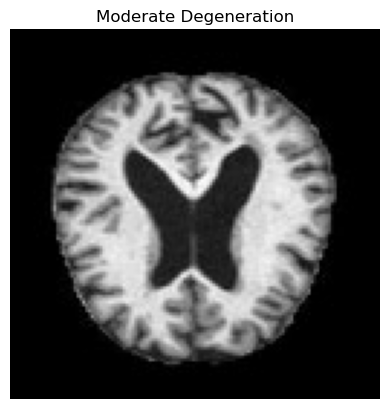

2024-11-17 17:16:01.264783: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


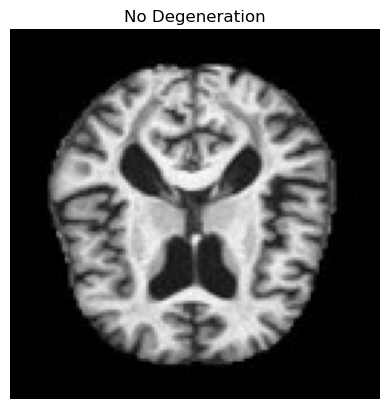

In [6]:
# Take a look at some of our sample MRI data
for image, label in ds_train.take(2): 
    # Convert image to numpy array and display with matplotlib 
    plt.imshow(image.numpy()) # Convert TensorFlow tensor to a NumPy array
    plt.title(alzheimers_state[label.numpy()]) # Print label
    plt.axis('off')
    plt.show()

In [17]:
# Batch our datasets
ds_train_batched = ds_train.batch(batch_size=64)
ds_valid_batched = ds_valid.batch(batch_size=64)

In [18]:
# import VGG16 pretrained base
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
base_model.trainable =False

In [19]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomContrast(factor=0.1),  # Adjust contrast
    tf.keras.layers.RandomBrightness(factor=0.1),  # Adjust brightness
    # Random rotation of +-10 degrees, to account for random head tilts in MRI images
    tf.keras.layers.RandomRotation(factor=0.1), 
    tf.keras.layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
    tf.keras.layers.RandomZoom(height_factor=0.1, width_factor=0.1)
])

In [20]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.regularizers import l2

model = keras.Sequential([
    # data_augmentation,
    base_model,
    layers.Flatten(),
    # layers.Dense(128, activation='relu', kernel_regularizer=l2(0.01)),
    # layers.Dropout(0.5),
    layers.Dense(64, activation='relu', kernel_regularizer=l2(0.01)),
    layers.Dense(4, activation='softmax'),
])

In [21]:
input_shape = (64, 128, 128, 3)
model.build(input_shape) # `input_shape` is the shape of the input data
                         # e.g. input_shape = (None, 32, 32, 3)
model.summary()


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten_2 (Flatten)         (None, 8192)              0         
                                                                 
 dense_4 (Dense)             (None, 64)                524352    
                                                                 
 dense_5 (Dense)             (None, 4)                 260       
                                                                 
Total params: 15,239,300
Trainable params: 524,612
Non-trainable params: 14,714,688
_________________________________________________________________


In [22]:
model.compile(
    optimizer='adam',
     # Labels are integers 0-3, use sparse categorical crossentropy for loss function
    loss = 'sparse_categorical_crossentropy',
    metrics = ['accuracy']
)


In [23]:
from tensorflow.keras import callbacks
earlystopping = callbacks.EarlyStopping(
    monitor='val_loss',
    mode='min',
    patience=5,
    restore_best_weights=True)

history = model.fit(
    ds_train_batched,
    validation_data=ds_valid_batched,
    epochs=60,
    verbose=True,
    callbacks=[earlystopping]
)

Epoch 1/60


2024-11-17 17:31:15.945943: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-11-17 17:31:16.037195: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp_2.


64/64 [==============================] - ETA: 0s - loss: 1.8807 - accuracy: 0.4934

2024-11-17 17:32:09.453331: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


64/64 [==============================] - 66s 1s/step - loss: 1.8807 - accuracy: 0.4934 - val_loss: 1.0952 - val_accuracy: 0.5664
Epoch 2/60
64/64 [==============================] - 67s 1s/step - loss: 1.0123 - accuracy: 0.6033 - val_loss: 1.0217 - val_accuracy: 0.6113
Epoch 3/60
64/64 [==============================] - 57s 896ms/step - loss: 0.9342 - accuracy: 0.6360 - val_loss: 0.9451 - val_accuracy: 0.6152
Epoch 4/60
64/64 [==============================] - 52s 811ms/step - loss: 0.8858 - accuracy: 0.6550 - val_loss: 0.9313 - val_accuracy: 0.6152
Epoch 5/60
64/64 [==============================] - 52s 818ms/step - loss: 0.8570 - accuracy: 0.6709 - val_loss: 0.9238 - val_accuracy: 0.6211
Epoch 6/60
64/64 [==============================] - 63s 984ms/step - loss: 0.8377 - accuracy: 0.6814 - val_loss: 0.9223 - val_accuracy: 0.6162
Epoch 7/60
64/64 [==============================] - 67s 1s/step - loss: 0.8223 - accuracy: 0.6904 - val_loss: 0.9219 - val_accuracy: 0.6328
Epoch 8/60
64/64 [=

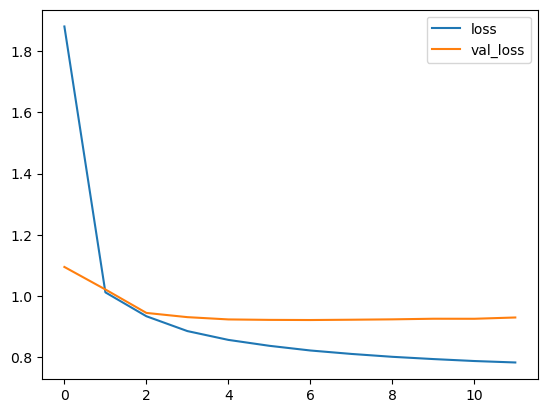

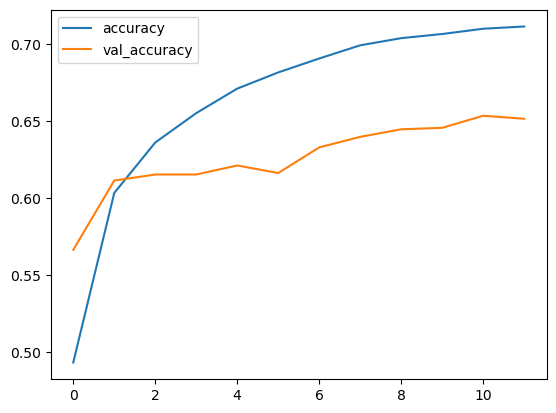

In [24]:
history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['accuracy', 'val_accuracy']].plot();

In [30]:
# Load the Falah/Alzheimer_MRI dataset

ds_test_ = load_dataset('Falah/Alzheimer_MRI', split='test')
# Generate predictions from the test dataset
ds_test_ = ds_test_.to_tf_dataset(columns='image', shuffle=False, label_cols='label')

ds_test = (
    ds_test_
    .map(preprocess)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
    .batch(batch_size=64)
)

predictions = model.predict(ds_test)

# Convert probabilities to class predictions
predicted_classes = tf.argmax(predictions, axis=1).numpy()

# Extract true labels from the test dataset
true_classes = tf.concat([label for image, label in ds_test], axis=0).numpy()

20/20 [==============================] - 9s 435ms/step


In [32]:
from sklearn.metrics import classification_report

# Generate classification report
report = classification_report(true_classes, predicted_classes, labels=(0,1,2,3), target_names=("No Alzheimers", "Mild", "Moderate", "Severe"))
print(report)

               precision    recall  f1-score   support

No Alzheimers       0.59      0.33      0.42       172
         Mild       0.00      0.00      0.00        15
     Moderate       0.88      0.56      0.68       634
       Severe       0.52      0.89      0.66       459

     accuracy                           0.64      1280
    macro avg       0.50      0.44      0.44      1280
 weighted avg       0.70      0.64      0.63      1280



/Users/nicopoliczer/miniconda3/envs/alzheimers_mri/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/nicopoliczer/miniconda3/envs/alzheimers_mri/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/nicopoliczer/miniconda3/envs/alzheimers_mri/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  